Before EDA let's reroll a bit:

In `1_load_data__understand.ipynb` notebook in `\notebooks\testing` we;
* load data
* Set index to `PassengerId` feature
* Get some kind of understanding from bird view on dataset
  * We find Null values and Decided actions such
    * `Age` attribute has *177* NaN
      * Fill up with a regression model (not decided yet)
    * `Cabin` attribute has *687* NaN
      * First we will extract `CabinType` then delete `Cabin` feature
      * Second We will fill up with a classification model (not decided yet)
    * `Embarked` attribute has *2* NaN
      * Simple Classification will enough for filling
* Detecting Outliers;
  * We will search for `Age` and `Fare` attributes for outliers
* We will create some new features;
  * From `Age` --> Create `AgeBucket` --> Delete `Age` If good for model
  * From `Name` --> Create `Title` and `FamilySize` --> Delete `Name`
  * From `SibSp` and `Parch` --> Create `RelativesOnBoard` --> Delete `SibSp` and `Parch` If good for model
  * From `Ticket` --> Create `DoesHaveSameTicket` --> Delete `Ticket`
  * From `Cabin` --> Create `CabinType` --> Delete `Cabin`
* We found out skewness
  * `Fare` feature has positive skewness; we will handle with **log transformation**
  * `Age` feature has possible skewness; bu will ignore it because we won't use this feature directly
* Encoding;
  * `Sex`, `Embarked`, `DoesHaveSameTicket`(We will create), `Title`(We will create) and `CabinType`(We will create) will use **OneHotEncode**
  * `Pclass` will use **OrdinalEncode**

Let's Create data preprocessing guideline:

1. Fill up NaN values
2. Search for Outliers
3. Create Features
4. Handle Skewness if has it
5. Encode

| Feature | Steps |
| ------- | :--: |
| `Pclass` | 5 |
| `Name` | 3 |
| `Sex` | 5 |
| `Age` | 1, 2, 3, 4 (if not deleted) |
| `SibSp` | 3 |
| `Parch` | 3 |
| `Ticket` | 3 |
| `Fare` | 2, 4 |
| `Cabin` | 3 |
| `Embarked` | 1, 5 |

**Feature Creation And Deletions**
| Feature From | New Feature | New Feature Steps | Deletion of Old one? |
| ------------ | ----------- | :---------------: | :-------------: |
| `Name` | `Title` | 5, 2, 5 | Yes |
| `Name` | `FamilySize` | | Yes |
| `Age` | `AgeBucket` | | Decide by score |
| `SibSp` and `Parch` | `RelativesOnBoard` | | Decide by score |
| `Ticket` | `DoesHaveSameTicket` | 5 | Yes |
| `Cabin` | `CabinType` | 5 | Yes |

* `Name`, `Ticket` and `Cabin` features after creating new features will **DELETED**.
* `Age`, `SibSp` and `Parch` features after creating new features, we will see impact on a model then decided for deleted or not.

**Note:**
I did not include scaling for now.

These inferences are after first glance from dataset; can add to it or reduce it. I want to write now before EDA, because I will much more deep info after EDA, then I can review my first view and determine my actions accordingly.

---

# EDA

###### Setup

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)

Let's load and split the data again:

In [3]:
# Load
train_data = pd.read_csv('../../data/train.csv')
test_data = pd.read_csv('../../data/test.csv')

# Set index
train_data = train_data.set_index('PassengerId')
test_data = test_data.set_index('PassengerId')

## First Let's split data according of their data types:

In [4]:
train_data_num = train_data.select_dtypes(include=[np.number])
train_data_obj = train_data.select_dtypes(include="object")

print(f"Numerical Columns: {list(train_data_num.columns)}")
print(f"Object Columns: {list(train_data_obj.columns)}")

Numerical Columns: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Object Columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


Let's see unique counts of these data types; and then we will determine more specific data types for EDA

In [5]:
print(train_data[train_data_num.columns].nunique(), end="\n\n")
print(train_data[train_data_obj.columns].nunique())

Survived      2
Pclass        3
Age          88
SibSp         7
Parch         7
Fare        248
dtype: int64

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64


* For Numerical as we can see `Pclass`, `SibSp`, `Parch` has not many unique values, and `Age` and `Fare` a lot of unique values, and lastly `Survived` attribute is target.
* For Object: As we can see `Sex` and `Embarked` are least uniques that appropriate for setting as **categorical attributes**. `Ticket`, `Cabin` and `Name` are more like a text data that uniqueness count is high; we can set these as **cardinal attributes**. 

In [6]:
train_data_discrete_num = train_data[['Pclass', 'SibSp', 'Parch']]
train_data_continuous_num = train_data[['Age', 'Fare']]

train_data_cat = train_data[['Sex', 'Embarked']]
train_data_car = train_data[['Ticket', 'Cabin', 'Name']]

train_data_target = train_data['Survived']

# Let's see first 3 data
print(train_data_discrete_num[:3], end="\n\n")
print(train_data_continuous_num[:3], end="\n\n")
print(train_data_cat[:3], end="\n\n")
print(train_data_car[:3], end="\n\n")
print(train_data_target[:3])

             Pclass  SibSp  Parch
PassengerId                      
1                 3      1      0
2                 1      1      0
3                 3      0      0

              Age     Fare
PassengerId               
1            22.0   7.2500
2            38.0  71.2833
3            26.0   7.9250

                Sex Embarked
PassengerId                 
1              male        S
2            female        C
3            female        S

                       Ticket Cabin                                               Name
PassengerId                                                                           
1                   A/5 21171   NaN                            Braund, Mr. Owen Harris
2                    PC 17599   C85  Cumings, Mrs. John Bradley (Florence Briggs Th...
3            STON/O2. 3101282   NaN                             Heikkinen, Miss. Laina

PassengerId
1    0
2    1
3    1
Name: Survived, dtype: int64


**Note:** these assignments only for EDA, we will redo for ML.

Let's recap:

In [7]:
print(f"All numerical Columns: \t{list(train_data_num.columns)}")
print(f"All Object Columns: \t{list(train_data_obj.columns)}\n")
print(f"Discrete Numerical Columns: \t{list(train_data_discrete_num.columns)}")
print(f"Continues Numerical Columns: \t{list(train_data_continuous_num.columns)}\n")
print(f"Categorical Columns: \t{list(train_data_cat.columns)}")
print(f"Cardinal Columns: \t{list(train_data_car.columns)}")

All numerical Columns: 	['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
All Object Columns: 	['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

Discrete Numerical Columns: 	['Pclass', 'SibSp', 'Parch']
Continues Numerical Columns: 	['Age', 'Fare']

Categorical Columns: 	['Sex', 'Embarked']
Cardinal Columns: 	['Ticket', 'Cabin', 'Name']


## Visualizing the Data

Let's see first Survival Rates

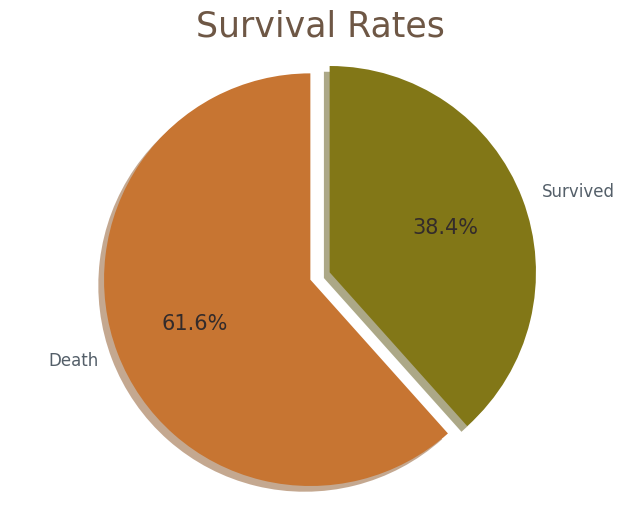

In [97]:
survival_rates = train_data_target.value_counts() / train_data_target.value_counts().sum()

plt.figure(figsize=(8, 6))
_, _, autopcts = plt.pie(survival_rates, labels=['Death', 'Survived'],
                         autopct='%1.1f%%', colors=['#C77532', '#827717'], startangle=90,
                         explode=[0, 0.1],
                         shadow={'ox': -0.02,
                                 'edgecolor': 'none', 'shade': 0.3},
                         textprops={'color': "#545f69", 'fontsize': 12})

plt.title('Survival Rates', fontdict={'color': "#6E5745", 'fontsize': 25})

for autopct in autopcts:
    autopct.set_color('#332B2B')
    autopct.set_fontsize(15)

plt.axis('equal')
plt.show()

As we can see only 38.4% survived, that's really sad. Let's see more deeply; Who survived why.